In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import datetime
import torch
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

In [2]:
def list_data(dir):
    data_dict = {}
    for dirname, _, filenames in os.walk(dir):
        for filename in filenames:
            path = os.path.join(dirname, filename)
            *_, label, key = path.split('/')
            data_dict[key] = data_dict.get(key, {})
            if label == 'images':
                data_dict[key]['img_path'] = path
            elif label == 'infection masks':
                data_dict[key]['label'] = path
    
    return list(data_dict.values())

In [3]:
class CustomDataset(Dataset):
    def __init__(self, data, img_transform=None, label_transform=None):

        self.data = data
        self.img_transform = img_transform
        self.label_transform = label_transform

    def __getitem__(self, idx):
        try:
            image = Image.open(self.data[idx]['img_path']).convert('L')
            label = Image.open(self.data[idx]['label']).convert('L')
            if self.img_transform and self.label_transform:
                image = self.img_transform(image)
                label = self.label_transform(label)
            image = image.squeeze(0)
            label = label.squeeze(0)
            return image, label
        
        except:
            print('Fail')
            print(idx)
            return 
    
    def __len__(self):
        return len(self.data)

In [4]:
def rmse(pred, target):
    assert pred.shape == target.shape
    diff = pred - target
    rmse = torch.sqrt(torch.mean(torch.pow(diff, 2)))
    return rmse

In [5]:
class TrainingLoop():
    def __init__(self, model: torch.nn.Module,
                        root: str,
                        batch_size: int,
                        loss_fn,
                        optim_fn: torch.optim,
                        lr: float,
                        img_transform: torchvision.transforms,
                        label_transform: torchvision.transforms,
                        data_split_ratio = 0.8):

        self.model = model
        self.batch_size = batch_size
        self.loss_fn = loss_fn
        self.optimizer = optim_fn(self.model.parameters(), lr)
        self.img_transform = img_transform
        self.label_transform = label_transform

        train_data = list_data(f'{root}/Train')
        val_data = list_data(f'{root}/Val')
        train_dataset = CustomDataset(train_data, img_transform, label_transform)
        val_dataset = CustomDataset(val_data, img_transform, label_transform)

        self.train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
        self.val_loader = DataLoader(val_dataset, batch_size, shuffle=False)

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.loss_fn.to(self.device)
        self.model.to(self.device)

    def train(self, n_epochs, save_name, eval_interval=5):
        save_path = os.path.join('runs', f"{save_name}{datetime.datetime.now()}" )
        if os.path.exists(save_path):
            print(f"There is a folder named {save_name} in runs/")
            return
        else:
            os.makedirs(save_path)

        min_rmse = 9999

        print(f"{datetime.datetime.now()} Start train on device {self.device}")

        for epoch in range(1, n_epochs + 1):
            self.model.train()
            print(f"Epoch {epoch}")
            train_losses = []

            for images, labels in tqdm(self.train_loader, desc="Training"):
                images = images.to(self.device)
                labels = labels.to(self.device)
                self.optimizer.zero_grad()

                out = self.model(images.unsqueeze(1))
                train_loss = self.loss_fn(out.squeeze(1), labels)

                train_loss.backward()
                self.optimizer.step()
                train_losses.append(train_loss.item())

            mean_train_loss = sum(train_losses)/len(train_losses)
            print(f"{datetime.datetime.now()} Epoch {epoch}: Training loss: {mean_train_loss}")

            torch.save(self.model.state_dict(), os.path.join(save_path, "last_ckpt.pt"))
            if epoch == 1 or epoch % eval_interval == 0:
                self.model.eval()
                rmse_scores = []

                for images, labels in tqdm(self.val_loader, desc="Validating"):
                    images = images.to(self.device)
                    labels = labels.to(self.device)

                    with torch.no_grad():
                        out = self.model(images.unsqueeze(1))
                                                
                        rmse_score = rmse(out.squeeze(1), labels)
                    
                    rmse_scores.append(rmse_score.item())

                mean_rmse = sum(rmse_scores)/len(rmse_scores)
                if mean_rmse < min_rmse:
                    min_rmse = mean_rmse
                    torch.save(self.model.state_dict(), os.path.join(save_path, "best_ckpt.pt"))

                print(f"{datetime.datetime.now()} Val RMSE {mean_rmse}")
                print("="*70)
                print("")

        return

In [9]:
lr = 0.001
optim_fn = optim.Adam
# loss = torch.nn.MSELoss()
loss = torch.nn.BCELoss()
n_epochs = 50
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])
root = '/kaggle/input/covidqu/Infection Segmentation Data/Infection Segmentation Data'
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', in_channels=1,\
                       out_channels=1, init_features=8, pretrained=False)

train_loop = TrainingLoop(model, root, 8, loss, optim_fn, lr, transform, transform)
train_loop.train(n_epochs, 'save')

Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


2024-03-20 04:00:41.472413 Start train on device cuda
Epoch 1


Training: 100%|██████████| 466/466 [01:30<00:00,  5.16it/s]


2024-03-20 04:02:11.783419 Epoch 1: Training loss: 0.3883525504382895


Validating: 100%|██████████| 117/117 [00:19<00:00,  5.88it/s]


2024-03-20 04:02:31.704092 Val RMSE 0.2265168578706236

Epoch 2


Training: 100%|██████████| 466/466 [00:30<00:00, 15.45it/s]


2024-03-20 04:03:01.871147 Epoch 2: Training loss: 0.17034351873679224
Epoch 3


Training: 100%|██████████| 466/466 [00:30<00:00, 15.45it/s]


2024-03-20 04:03:32.043127 Epoch 3: Training loss: 0.12674439947876295
Epoch 4


Training: 100%|██████████| 466/466 [00:30<00:00, 15.51it/s]


2024-03-20 04:04:02.102746 Epoch 4: Training loss: 0.10546405694963083
Epoch 5


Training: 100%|██████████| 466/466 [00:30<00:00, 15.47it/s]


2024-03-20 04:04:32.244724 Epoch 5: Training loss: 0.09253759177745412


Validating: 100%|██████████| 117/117 [00:04<00:00, 25.80it/s]


2024-03-20 04:04:36.811821 Val RMSE 0.1493387744208782

Epoch 6


Training: 100%|██████████| 466/466 [00:30<00:00, 15.46it/s]


2024-03-20 04:05:06.956927 Epoch 6: Training loss: 0.08549755126189904
Epoch 7


Training: 100%|██████████| 466/466 [00:30<00:00, 15.48it/s]


2024-03-20 04:05:37.089214 Epoch 7: Training loss: 0.0824487027612239
Epoch 8


Training: 100%|██████████| 466/466 [00:30<00:00, 15.51it/s]


2024-03-20 04:06:07.147331 Epoch 8: Training loss: 0.07518351293077029
Epoch 9


Training: 100%|██████████| 466/466 [00:30<00:00, 15.52it/s]


2024-03-20 04:06:37.204315 Epoch 9: Training loss: 0.07152446840446075
Epoch 10


Training: 100%|██████████| 466/466 [00:30<00:00, 15.31it/s]


2024-03-20 04:07:07.653647 Epoch 10: Training loss: 0.06937646584849116


Validating: 100%|██████████| 117/117 [00:04<00:00, 26.50it/s]


2024-03-20 04:07:12.102419 Val RMSE 0.1101366125781519

Epoch 11


Training: 100%|██████████| 466/466 [00:30<00:00, 15.41it/s]


2024-03-20 04:07:42.340272 Epoch 11: Training loss: 0.06663257819340593
Epoch 12


Training: 100%|██████████| 466/466 [00:30<00:00, 15.36it/s]


2024-03-20 04:08:12.704868 Epoch 12: Training loss: 0.06329603228306342
Epoch 13


Training: 100%|██████████| 466/466 [00:30<00:00, 15.48it/s]


2024-03-20 04:08:42.822479 Epoch 13: Training loss: 0.05996037388915924
Epoch 14


Training: 100%|██████████| 466/466 [00:30<00:00, 15.51it/s]


2024-03-20 04:09:12.881398 Epoch 14: Training loss: 0.05770409174159553
Epoch 15


Training: 100%|██████████| 466/466 [00:30<00:00, 15.46it/s]


2024-03-20 04:09:43.044368 Epoch 15: Training loss: 0.055875365962094505


Validating: 100%|██████████| 117/117 [00:04<00:00, 25.93it/s]


2024-03-20 04:09:47.573965 Val RMSE 0.16435257866421443

Epoch 16


Training: 100%|██████████| 466/466 [00:29<00:00, 15.54it/s]


2024-03-20 04:10:17.568020 Epoch 16: Training loss: 0.05305479695748681
Epoch 17


Training: 100%|██████████| 466/466 [00:30<00:00, 15.29it/s]


2024-03-20 04:10:48.071750 Epoch 17: Training loss: 0.05323089499030534
Epoch 18


Training: 100%|██████████| 466/466 [00:31<00:00, 14.99it/s]


2024-03-20 04:11:19.174870 Epoch 18: Training loss: 0.05244970966985873
Epoch 19


Training: 100%|██████████| 466/466 [00:31<00:00, 14.63it/s]


2024-03-20 04:11:51.050480 Epoch 19: Training loss: 0.04815833283040689
Epoch 20


Training: 100%|██████████| 466/466 [00:31<00:00, 14.85it/s]


2024-03-20 04:12:22.445049 Epoch 20: Training loss: 0.04727411377163756


Validating: 100%|██████████| 117/117 [00:04<00:00, 23.81it/s]


2024-03-20 04:12:27.391706 Val RMSE 0.10123387337254329

Epoch 21


Training: 100%|██████████| 466/466 [00:31<00:00, 14.73it/s]


2024-03-20 04:12:59.030984 Epoch 21: Training loss: 0.04353481256642854
Epoch 22


Training: 100%|██████████| 466/466 [00:31<00:00, 14.73it/s]


2024-03-20 04:13:30.689021 Epoch 22: Training loss: 0.04208502235503611
Epoch 23


Training: 100%|██████████| 466/466 [00:31<00:00, 14.84it/s]


2024-03-20 04:14:02.108130 Epoch 23: Training loss: 0.041986628782299903
Epoch 24


Training: 100%|██████████| 466/466 [00:31<00:00, 14.94it/s]


2024-03-20 04:14:33.309278 Epoch 24: Training loss: 0.03736271478221732
Epoch 25


Training: 100%|██████████| 466/466 [00:31<00:00, 14.93it/s]


2024-03-20 04:15:04.531502 Epoch 25: Training loss: 0.03718049291775126


Validating: 100%|██████████| 117/117 [00:04<00:00, 24.39it/s]


2024-03-20 04:15:09.360654 Val RMSE 0.09819505206355526

Epoch 26


Training: 100%|██████████| 466/466 [00:31<00:00, 15.02it/s]


2024-03-20 04:15:40.392529 Epoch 26: Training loss: 0.0341537774038599
Epoch 27


Training: 100%|██████████| 466/466 [00:30<00:00, 15.43it/s]


2024-03-20 04:16:10.617097 Epoch 27: Training loss: 0.03682543823241692
Epoch 28


Training: 100%|██████████| 466/466 [00:30<00:00, 15.11it/s]


2024-03-20 04:16:41.475173 Epoch 28: Training loss: 0.033424819545328714
Epoch 29


Training: 100%|██████████| 466/466 [00:30<00:00, 15.11it/s]


2024-03-20 04:17:12.323636 Epoch 29: Training loss: 0.03335449095868381
Epoch 30


Training: 100%|██████████| 466/466 [00:31<00:00, 14.94it/s]


2024-03-20 04:17:43.525616 Epoch 30: Training loss: 0.030725547780913336


Validating: 100%|██████████| 117/117 [00:04<00:00, 24.15it/s]


2024-03-20 04:17:48.404068 Val RMSE 0.09766406712617773

Epoch 31


Training: 100%|██████████| 466/466 [00:30<00:00, 15.11it/s]


2024-03-20 04:18:19.250468 Epoch 31: Training loss: 0.031521005527008435
Epoch 32


Training: 100%|██████████| 466/466 [00:30<00:00, 15.11it/s]


2024-03-20 04:18:50.117602 Epoch 32: Training loss: 0.0365244619197451
Epoch 33


Training: 100%|██████████| 466/466 [00:30<00:00, 15.36it/s]


2024-03-20 04:19:20.468896 Epoch 33: Training loss: 0.027449284553779648
Epoch 34


Training: 100%|██████████| 466/466 [00:30<00:00, 15.30it/s]


2024-03-20 04:19:50.935654 Epoch 34: Training loss: 0.026955751511765456
Epoch 35


Training: 100%|██████████| 466/466 [00:30<00:00, 15.39it/s]


2024-03-20 04:20:21.234605 Epoch 35: Training loss: 0.02832824807657057


Validating: 100%|██████████| 117/117 [00:04<00:00, 25.33it/s]


2024-03-20 04:20:25.869978 Val RMSE 0.10372704972535905

Epoch 36


Training: 100%|██████████| 466/466 [00:30<00:00, 15.30it/s]


2024-03-20 04:20:56.329994 Epoch 36: Training loss: 0.02582486785744425
Epoch 37


Training: 100%|██████████| 466/466 [00:30<00:00, 15.43it/s]


2024-03-20 04:21:26.548081 Epoch 37: Training loss: 0.030012049358498
Epoch 38


Training: 100%|██████████| 466/466 [00:30<00:00, 15.40it/s]


2024-03-20 04:21:56.824682 Epoch 38: Training loss: 0.02449518553029532
Epoch 39


Training: 100%|██████████| 466/466 [00:30<00:00, 15.41it/s]


2024-03-20 04:22:27.092479 Epoch 39: Training loss: 0.02361065619552704
Epoch 40


Training: 100%|██████████| 466/466 [00:30<00:00, 15.50it/s]


2024-03-20 04:22:57.171083 Epoch 40: Training loss: 0.023572730492236384


Validating: 100%|██████████| 117/117 [00:04<00:00, 25.63it/s]


2024-03-20 04:23:01.758071 Val RMSE 0.09772378497129669

Epoch 41


Training: 100%|██████████| 466/466 [00:30<00:00, 15.34it/s]


2024-03-20 04:23:32.146575 Epoch 41: Training loss: 0.02265241036947033
Epoch 42


Training: 100%|██████████| 466/466 [00:30<00:00, 15.39it/s]


2024-03-20 04:24:02.438772 Epoch 42: Training loss: 0.022567414061582042
Epoch 43


Training: 100%|██████████| 466/466 [00:30<00:00, 15.33it/s]


2024-03-20 04:24:32.856650 Epoch 43: Training loss: 0.02225198005446005
Epoch 44


Training: 100%|██████████| 466/466 [00:30<00:00, 15.52it/s]


2024-03-20 04:25:02.893269 Epoch 44: Training loss: 0.021329478743590282
Epoch 45


Training: 100%|██████████| 466/466 [00:30<00:00, 15.39it/s]


2024-03-20 04:25:33.191165 Epoch 45: Training loss: 0.020770914330171066


Validating: 100%|██████████| 117/117 [00:04<00:00, 26.12it/s]


2024-03-20 04:25:37.703117 Val RMSE 0.09687839657868981

Epoch 46


Training: 100%|██████████| 466/466 [00:29<00:00, 15.54it/s]


2024-03-20 04:26:07.689170 Epoch 46: Training loss: 0.02120900851138018
Epoch 47


Training: 100%|██████████| 466/466 [00:31<00:00, 14.76it/s]


2024-03-20 04:26:39.274374 Epoch 47: Training loss: 0.020498674148054147
Epoch 48


Training: 100%|██████████| 466/466 [00:31<00:00, 14.61it/s]


2024-03-20 04:27:11.178134 Epoch 48: Training loss: 0.02182486941668209
Epoch 49


Training: 100%|██████████| 466/466 [00:32<00:00, 14.51it/s]


2024-03-20 04:27:43.309159 Epoch 49: Training loss: 0.01960855218578233
Epoch 50


Training: 100%|██████████| 466/466 [00:31<00:00, 14.64it/s]


2024-03-20 04:28:15.158688 Epoch 50: Training loss: 0.01856330909782245


Validating: 100%|██████████| 117/117 [00:05<00:00, 20.94it/s]

2024-03-20 04:28:20.762333 Val RMSE 0.09988679799488069



In [11]:
class ImageSegmentation():
    def __init__(self, model_path = "/kaggle/working/runs/save2024-03-20 04:00:41.472220/best_ckpt.pt"):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', in_channels=1, out_channels=1, init_features=8, pretrained=False)
        self.model.load_state_dict(torch.load(model_path, map_location = self.device))
        self.model.eval()

    @torch.inference_mode()
    def segment(self, image):
        tf = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor()])
        image = tf(image)
        image.unsqueeze_(0)
        out = self.model(image)
        return image, out


Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


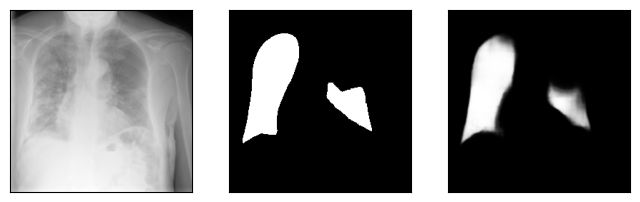

In [16]:
segmenter = ImageSegmentation()
img = Image.open("/kaggle/input/covidqu/Infection Segmentation Data/Infection Segmentation Data/Test/COVID-19/images/covid_1590.png")
gt = Image.open('/kaggle/input/covidqu/Infection Segmentation Data/Infection Segmentation Data/Test/COVID-19/infection masks/covid_1590.png')
image, out = segmenter.segment(img)
reversed_tf = transforms.ToPILImage()
out = reversed_tf(out.squeeze(0))
image = reversed_tf(image.squeeze(0))

plt.figure(figsize = (8,8))
plt.subplot(131), plt.imshow(image, cmap = "gray")
plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(gt, cmap = "gray")
plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(out, cmap = "gray")
plt.xticks([]), plt.yticks([])
plt.show()